In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm
from sklearn.neighbors import KNeighborsClassifier

# 나눔글꼴 경로 설정
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'

# 폰트 이름 가져오기
font_name = fm.FontProperties(fname=font_path).get_name()

# 폰트 설정
plt.rc('font', family=font_name)
warnings.filterwarnings('ignore')

In [123]:
df = pd.read_csv('../01. Data/train.csv')
df

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


# Preprocessing
- drop NaN

In [ ]:
df = df[~df['근로기간'].isna()].reset_index(drop=True)
df

In [125]:
df = df.drop(columns='ID')
df

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


### 데이터 내 불필요한 요소 수정/제거

In [126]:
mapper = {'1 year' : 1,
          '1 years' : 1,
          '10+ years' : 10,
          '10+years' : 10,
          '2 years' : 2,
          '3' : 3,
          '3 years' : 3,
          '4 years' : 4,
          '5 years' : 5,
          '6 years' : 6,
          '7 years' : 7,
          '8 years' : 8,
          '9 years' : 9,
          '< 1 year' : 0,
          '<1 year' : 0,
          'Unknown' : np.nan}

In [127]:
df['근로기간'] = df['근로기간'].map(mapper)
df

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,NaN,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10.0,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10.0,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1.0,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5.0,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [128]:
df['대출기간'] = df['대출기간'].map({' 36 months':36, ' 60 months':60})
df

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36,8.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60,NaN,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36,10.0,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60,10.0,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36,1.0,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36,5.0,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [129]:
#df.to_csv('./sample_data02.csv', index=False)

In [130]:
df = df[~df['근로기간'].isna()].reset_index(drop=True)
df

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36,6.0,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60,10.0,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36,5.0,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36,8.0,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,4800000,36,10.0,RENT,84000000,13.78,30,휴가,0,240216,55428.0,0.0,0.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90618,14400000,36,10.0,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
90619,28800000,60,10.0,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
90620,14400000,36,1.0,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
90621,15600000,36,5.0,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [131]:
from sklearn.preprocessing import LabelEncoder

## Get Dummies

In [132]:
df['대출등급'].value_counts()

대출등급
B    27075
C    25995
A    15838
D    12482
E     6976
F     1862
G      395
Name: count, dtype: int64

In [133]:
# 가변수화 시킬 column
col = [
       '근로기간', 
       '대출기간', 
       '주택소유상태', 
       '총계좌수', 
       '대출목적',
       '최근_2년간_연체_횟수', 
       '연체계좌수'
      ]

In [134]:
for name in col :
    df = df.join(pd.get_dummies(df[name], drop_first=True, prefix=name))
df.drop(columns=col, inplace=True)

In [135]:
df

,대출금액,연간소득,부채_대비_소득_비율,총상환원금,총상환이자,총연체금액,대출등급,근로기간_1.0,근로기간_2.0,근로기간_3.0,...,최근_2년간_연체_횟수_13,최근_2년간_연체_횟수_14,최근_2년간_연체_횟수_15,최근_2년간_연체_횟수_16,최근_2년간_연체_횟수_17,최근_2년간_연체_횟수_18,최근_2년간_연체_횟수_30,연체계좌수_1.0,연체계좌수_2.0,연체계좌수_4.0
0,12480000,72000000,18.90,0,0.0,0.0,C,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,14400000,130800000,22.33,373572,234060.0,0.0,B,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,12000000,96000000,8.60,928644,151944.0,0.0,A,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,14400000,132000000,15.09,325824,153108.0,0.0,C,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4800000,84000000,13.78,240216,55428.0,0.0,A,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90618,14400000,210000000,9.33,974580,492168.0,0.0,C,False,False,False,...,False,False,False,False,False,False,False,False,False,False
90619,28800000,132000000,5.16,583728,855084.0,0.0,E,False,False,False,...,False,False,False,False,False,False,False,False,False,False
90620,14400000,84000000,11.24,1489128,241236.0,0.0,A,True,False,False,...,False,False,False,False,False,False,False,False,False,False
90621,15600000,66330000,17.30,1378368,818076.0,0.0,D,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Train_test_split

In [136]:
X = df.drop(columns='대출등급')
y = df['대출등급']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(63436, 161)
(27187, 161)
(63436,)
(27187,)


## Over Sampling

In [138]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## Standard Scaling

In [139]:
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train_res)
X_test_standard = standard_scaler.transform(X_test)

#### GridSearch / RandomizedSearch Failure

In [51]:
# depth_grid_rf = np.arange(2, 10)
# n_estimators_rf = np.arange(300, 1000, 100)
# max_leaf_nodes_rf_grid = np.arange(1, 20, 3)
# min_sample_leaf_rf_grid = np.arange(1, 20, 3)

In [52]:
# parameter_rf = {'max_depth':depth_grid_rf,
#                 'n_estimators':n_estimators_rf,
#                 'min_samples_leaf':min_sample_leaf_rf_grid,
#                 'max_leaf_nodes':max_leaf_nodes_rf_grid}

In [53]:
# parameter_rf

{'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'n_estimators': array([300, 400, 500, 600, 700, 800, 900]),
 'min_samples_leaf': array([ 1,  4,  7, 10, 13, 16, 19]),
 'max_leaf_nodes': array([ 1,  4,  7, 10, 13, 16, 19])}

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# RandomForest

In [81]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=10)
rf.fit(X_train_standard, y_train_res)
pred_rf_standard = rf.predict(X_test_standard)

# gridCV_rf = RandomizedSearchCV(RandomForestClassifier(),
#                          param_distributions=parameter_rf,
#                          cv=10, n_jobs=-1)
# gridCV_rf.fit(X_train_standard, y_train_res)
# pred_grid_rf_standard = gridCV_rf.predict(X_test_standard)


conf_mat = confusion_matrix(y_test, pred_rf_standard)
conf_mat

array([[3385, 1098,  150,    0,   51,    1,    0],
       [2703, 3468, 1231,   33,  600,   71,    7],
       [ 884, 2535, 2517,   80, 1331,  356,  111],
       [ 188,  691, 1276,   90,  866,  483,  133],
       [  31,  187,  589,   59,  570,  545,  177],
       [   3,   26,  103,   20,   83,  246,  106],
       [   0,    4,   10,    2,   10,   49,   28]], dtype=int64)

In [95]:
f1_rf = metrics.f1_score(y_test, pred_grid_rf_standard, average='micro')

In [83]:
print(classification_report(y_test, pred_rf_standard))

              precision    recall  f1-score   support

           A       0.47      0.72      0.57      4685
           B       0.43      0.43      0.43      8113
           C       0.43      0.32      0.37      7814
           D       0.32      0.02      0.04      3727
           E       0.16      0.26      0.20      2158
           F       0.14      0.42      0.21       587
           G       0.05      0.27      0.08       103

    accuracy                           0.38     27187
   macro avg       0.29      0.35      0.27     27187
weighted avg       0.39      0.38      0.36     27187



In [ ]:
n_estimators_ada = np.arange(100, 800, 100)
learning_rate_ada = np.arange(0.01, 0.06, 0.01)

In [ ]:
parameter_ada = {
    'n_estimators' : n_estimators_ada
    'learning_rate' : learning_rate_ada
}

In [ ]:
parameter_ada

## AdaBoost
- DecisionTree

In [76]:
ada = AdaBoostClassifier(DecisionTreeClassifier(),
                        n_estimators=500,
                        learning_rate=0.01)
ada.fit(X_train_standard, y_train_res)
pred_ada_standard = ada.predict(X_test_standard)

# gridCV_ada = GridSearchCV(AdaBoostClassifier(),
#                          param_grid=parameter_ada,
#                          cv=10, n_jobs=-1)
# gridCV_ada.fit(X_train_standard, y_train_res)
# pred_grid_ada_standard = gridCV_ada.predict(X_test_standard)


conf_mat = confusion_matrix(y_test, pred_ada_standard)
conf_mat

array([[4061,  498,   91,   27,    7,    1,    0],
       [ 621, 6641,  620,  181,   42,    7,    1],
       [ 106,  648, 6236,  619,  168,   31,    6],
       [  19,   68,  336, 2763,  455,   60,   26],
       [   4,   26,   61,  326, 1554,  154,   33],
       [   2,    7,   16,   21,   61,  426,   54],
       [   0,    1,    0,    0,    7,   19,   76]], dtype=int64)

In [80]:
print(classification_report(y_test, pred_ada_standard))

              precision    recall  f1-score   support

           A       0.84      0.87      0.86      4685
           B       0.84      0.82      0.83      8113
           C       0.85      0.80      0.82      7814
           D       0.70      0.74      0.72      3727
           E       0.68      0.72      0.70      2158
           F       0.61      0.73      0.66       587
           G       0.39      0.74      0.51       103

    accuracy                           0.80     27187
   macro avg       0.70      0.77      0.73     27187
weighted avg       0.80      0.80      0.80     27187



In [94]:
f1_ada = metrics.f1_score(y_test, pred_ada_standard, average='micro')

# XGBoost
- LabelEncoder

In [59]:
y_train_res

0         B
1         A
2         C
3         B
4         A
         ..
132729    G
132730    G
132731    G
132732    G
132733    G
Name: 대출등급, Length: 132734, dtype: object

In [60]:
encoder = LabelEncoder()
y_train_res_encoded = encoder.fit_transform(y_train_res)
y_train_res_encoded

array([1, 0, 2, ..., 6, 6, 6])

In [61]:
encoder.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G'], dtype=object)

In [62]:
y_test_encoded = encoder.transform(y_test)
y_test_encoded

array([1, 2, 0, ..., 1, 2, 1])

In [63]:
y_test

11471    B
60253    C
51045    A
65628    A
32947    B
        ..
80766    C
31977    F
30872    B
7230     C
86964    B
Name: 대출등급, Length: 27187, dtype: object

In [67]:
xgb = XGBClassifier(n_estimators=500,
                    max_depth=8,
                    learning_rate=0.03)
xgb.fit(X_train_standard, y_train_res_encoded)
pred_xgb_standard = xgb.predict(X_test_standard)

# randCV_xgb = RandomizedSearchCV(AdaBoostClassifier(),
#                          param_distributions=parameter_ada,
#                          cv=10, n_jobs=-1)
# randCV_xgb.fit(X_train_standard, y_train_res)
# pred_rand_xgb_standard = randCV_xgb.predict(X_test_standard)



conf_mat = confusion_matrix(y_test_encoded, pred_xgb_standard)
conf_mat

array([[4154,  492,   38,    1,    0,    0,    0],
       [ 530, 6979,  577,   23,    3,    1,    0],
       [  74,  628, 6774,  297,   40,    0,    1],
       [   7,   74,  588, 2579,  455,   18,    6],
       [   1,   22,  134,  356, 1523,  117,    5],
       [   1,    6,   34,   25,   65,  424,   32],
       [   0,    1,    4,    3,    3,   18,   74]], dtype=int64)

In [71]:
pred_xgb_standard

array([1, 0, 0, ..., 0, 3, 1], dtype=int64)

In [93]:
f1_xgb = metrics.f1_score(y_test_encoded, pred_xgb_standard, average='micro')

In [74]:
print(classification_report(y_test_encoded, pred_xgb_standard))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4685
           1       0.85      0.86      0.86      8113
           2       0.83      0.87      0.85      7814
           3       0.79      0.69      0.74      3727
           4       0.73      0.71      0.72      2158
           5       0.73      0.72      0.73       587
           6       0.63      0.72      0.67       103

    accuracy                           0.83     27187
   macro avg       0.78      0.78      0.78     27187
weighted avg       0.83      0.83      0.83     27187



## LightGBM

In [96]:
lgb = LGBMClassifier(max_depth=10, learning_rate=0.01)
lgb.fit(X_train_standard, y_train_res)
pred_lgb_standard = lgb.predict(X_test_standard)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 132734, number of used features: 125
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightG

In [97]:
conf_mat = confusion_matrix(y_test, pred_lgb_standard)
conf_mat

array([[4129,  512,   42,    0,    2,    0,    0],
       [1116, 6136,  803,   43,   12,    0,    3],
       [ 138, 1826, 5290,  427,  117,    2,   14],
       [  29,  219, 1202, 1103, 1079,   73,   22],
       [   4,   43,  332,  271, 1155,  323,   30],
       [   4,    9,   48,   28,   42,  385,   71],
       [   0,    2,    4,    2,    5,    7,   83]], dtype=int64)

In [100]:
f1_lgb = metrics.f1_score(y_test, pred_lgb_standard, average='micro')
f1_lgb

0.6724169639901424

In [99]:
print(classification_report(y_test, pred_lgb_standard))

              precision    recall  f1-score   support

           A       0.76      0.88      0.82      4685
           B       0.70      0.76      0.73      8113
           C       0.69      0.68      0.68      7814
           D       0.59      0.30      0.39      3727
           E       0.48      0.54      0.51      2158
           F       0.49      0.66      0.56       587
           G       0.37      0.81      0.51       103

    accuracy                           0.67     27187
   macro avg       0.58      0.66      0.60     27187
weighted avg       0.67      0.67      0.66     27187



## GradientBoosting

In [103]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_standard, y_train_res)
pred_gbc_standard = gbc.predict(X_test_standard)

In [104]:
conf_mat = confusion_matrix(y_test, pred_lgb_standard)
conf_mat

array([[4129,  512,   42,    0,    2,    0,    0],
       [1116, 6136,  803,   43,   12,    0,    3],
       [ 138, 1826, 5290,  427,  117,    2,   14],
       [  29,  219, 1202, 1103, 1079,   73,   22],
       [   4,   43,  332,  271, 1155,  323,   30],
       [   4,    9,   48,   28,   42,  385,   71],
       [   0,    2,    4,    2,    5,    7,   83]], dtype=int64)

In [105]:
f1_gbc = metrics.f1_score(y_test, pred_gbc_standard, average='micro')
f1_gbc

0.6601316805826314

In [106]:
print(classification_report(y_test, pred_gbc_standard))

              precision    recall  f1-score   support

           A       0.85      0.85      0.85      4685
           B       0.73      0.75      0.74      8113
           C       0.60      0.72      0.65      7814
           D       0.51      0.18      0.27      3727
           E       0.44      0.53      0.48      2158
           F       0.54      0.65      0.59       587
           G       0.44      0.77      0.56       103

    accuracy                           0.66     27187
   macro avg       0.59      0.63      0.59     27187
weighted avg       0.65      0.66      0.64     27187



In [141]:
f1_ada

0.8002721889138191

## Visualization for F1 Score
- Non Scaled / Standard Scaled Data

In [155]:
f1_list = [f1_rf, f1_lgb, f1_xgb, f1_gbc, f1_ada]
f1_data = ['RandomForest_std', 'LightGBM_std', 'XGBoost_std', 'GradientBoost_std', 'AdaBoost_std']
df_f1 = pd.DataFrame(data=f1_list, index=f1_data)

In [156]:
df_f1

,0
RandomForest_std,0.295178
LightGBM_std,0.672417
XGBoost_std,0.827859
GradientBoost_std,0.660132
AdaBoost_std,0.800272


In [160]:
df_f1.rename(columns={0:'F1 Score'}, inplace=True)
df_f1

,F1 Score
RandomForest_std,0.295178
LightGBM_std,0.672417
XGBoost_std,0.827859
GradientBoost_std,0.660132
AdaBoost_std,0.800272


In [161]:
df_f1 = np.round(df_f1, 3)

In [168]:
df_f1.reset_index(inplace=True)
df_f1

,index,F1 Score
0,RandomForest_std,0.295
1,LightGBM_std,0.672
2,XGBoost_std,0.828
3,GradientBoost_std,0.660
4,AdaBoost_std,0.800


In [170]:
df_f1.rename(columns={'index':'model'}, inplace=True)
df_f1

,model,F1 Score
0,RandomForest_std,0.295
1,LightGBM_std,0.672
2,XGBoost_std,0.828
3,GradientBoost_std,0.660
4,AdaBoost_std,0.800


In [171]:
df_f1_non_scaled = pd.read_csv('../01. Data/non_scaled.csv')
df_f1_non_scaled

,Unnamed: 0,model,F1 Score
0,0,ADA Boost,0.524
1,1,Random Forest,0.613
2,2,GBC,0.750
3,3,XGB Classifier,0.834
4,4,LGBM Classifier,0.845


In [175]:
df_f1_non_scaled = df_f1_non_scaled.iloc[:, 1:]

In [185]:
df_f1_non_scaled.sort_values(by='model', inplace=True)
df_f1_non_scaled = df_f1_non_scaled.reset_index(drop=True)
df_f1_non_scaled

,model,F1 Score
0,ADA Boost,0.524
1,GBC,0.750
2,LGBM Classifier,0.845
3,Random Forest,0.613
4,XGB Classifier,0.834


In [177]:
df_f1.rename(columns={'F1 Score':'F1 Score_std'}, inplace=True)

In [186]:
df_f1.sort_values(by='model', inplace=True)
df_f1 = df_f1.reset_index(drop=True)
df_f1

,model,F1 Score_std
0,AdaBoost_std,0.800
1,GradientBoost_std,0.660
2,LightGBM_std,0.672
3,RandomForest_std,0.295
4,XGBoost_std,0.828


In [188]:
df_f1.iloc[:, 1:]

,F1 Score_std
0,0.800
1,0.660
2,0.672
3,0.295
4,0.828


In [190]:
df_mod = df_f1_non_scaled.join(df_f1.iloc[:, 1:])
df_mod

,model,F1 Score,F1 Score_std
0,ADA Boost,0.524,0.800
1,GBC,0.750,0.660
2,LGBM Classifier,0.845,0.672
3,Random Forest,0.613,0.295
4,XGB Classifier,0.834,0.828


In [230]:
model_list = list(df_mod['model'])
model_list

['ADA Boost', 'GBC', 'LGBM Classifier', 'Random Forest', 'XGB Classifier']

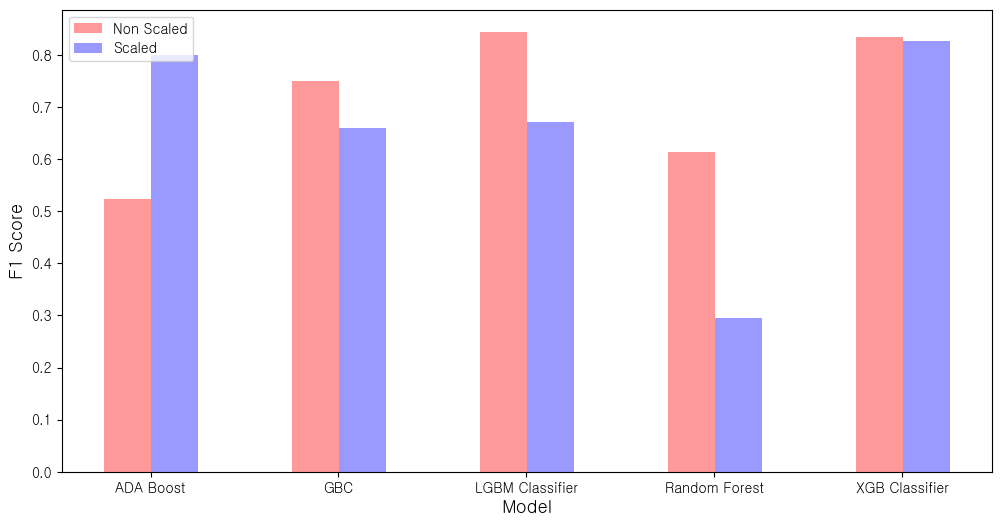

In [255]:
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

index = np.arange(5)

# 각 연도별로 3개 샵의 bar를 순서대로 나타내는 과정, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, df_mod['F1 Score'], bar_width, alpha=0.4, color='red', label='Non Scaled')

b2 = plt.bar(index + bar_width, df_mod['F1 Score_std'], bar_width, alpha=0.4, color='blue', label='Scaled')

# x축 위치를 정 가운데로 조정하고 x축의 텍스트를 year 정보와 매칭
# plt.xticks(np.arange(bar_width, 4 + bar_width, 1), ['ADA Boost', 'GBC', 'LGBM Classifier', 'Random Forest', 'XGB Classifier'])
plt.xticks(index + bar_width - 0.1285,df_mod['model'])
# x축, y축 이름 및 범례 설정
plt.xlabel('Model', size = 13)
plt.ylabel('F1 Score', size = 13)
plt.legend()
plt.show()